# Day 1: Introduction to RxRx19 dataset

Today we will be familiarizing ourselves with the dataset structure, and performing a few operations to understand it better.

## 1. Loading the datasets

The first step is to clone the repository with the data. The original dataset available on Kaggle has more than 305,520 images, with total size of >400 GB. Hence, we created a subset of 16,000 images and their labels.

> If you are curious to know how we created this subset, you can check [here](https://github.com/ai4all-sfu/comp-biology-2020/blob/master/day0-data-preprocessing.ipynb).



In [30]:
! git clone https://github.com/ai4all-sfu/comp-biology-2020.git

fatal: destination path 'comp-biology-2020' already exists and is not an empty directory.


To check if the files are available, we use the code below. We should see two folders: 'sample_data' and 'comp-biology-2020'.

In [11]:
!ls

comp-biology-2020  sample_data


Let us take a look at the structure of the dataset once again.

![alt text](https://drive.google.com/uc?id=1K8bj6FqO9mbz1hdbxK969B92PQvFxgdI)

RxRx19-images.zip consists of the image dataset. As discussed on the slides, two types of cells are being considered: HRCE and Vero cells. Each folder consists of cell images taken from 26 Plates. Each plate has ~26,000 images. Each cell site is passed through five channels, so each channel has ~5000 images. 

Let us take a look at the metadata and embeddings file. To reduce the size of the files, we saved them in pickle format. Let's unpickle them now.



In [15]:
import pandas as pd
import pickle

#pickle is used to serialize a python object structure into a byte stream; basically to handle it as a file with its size compressed.
embeddings = pd.read_pickle('comp-biology-2020/embeddings.pkl', compression = 'xz')
metadata = pd.read_pickle('comp-biology-2020/metadata.pkl', compression = 'xz')

#changing the index
embeddings.set_index('site_id', inplace=True)

Let us print the head of metadata.pkl so that we can understand what it contains.

In [ ]:
metadata.head()

## 2. Understanding the Data

* 'site_id': it refers to the cell site under consideration. Every cell site has a unique site_id. As we discussed, every cell is analyzed under 4 sites, and each site is analyzed under 5 different channels. The format of site_id is as follows: 'experiment_plate_well_site'. So each of these will have an image each for the five different channels. Recall the comparison chart between them from the slides. That image is given below for your reference.

![alt text](https://drive.google.com/uc?id=1MhREWlcUghzmwiMMVz8GXU_p6zWZYonu)

* 'disease_condition': it refers to whether the cell is infected with the SARS-CoV-2 virus or not. In the original 'metadata.csv' there were three disease conditions: Active SARS-CoV-2 (the cell has been infected with the virus), UV Inactivated SARS-CoV-2, and Mock (mock preparations of SARS-CoV-2 on cells). We combined the disease conditions 'UV Inactivated SARS-CoV-2' and 'Mock' into one class: 'Inactive' (because they are similar), so that we can consider two distinct classes in our classification task: 'Active' and 'Inactive'.

* 'treatment': it refers to the drug that is used to treat the cell from the virus, 'treatment_conc' refers to the amount of concentration that the drug is used under. For an 'inactive' cell site, the value under 'treatment' and 'treatment_conc' will be NaN. 

Let us print embeddings.pkl and take a look at its head.

In [ ]:
embeddings.head()

In the above result, for every site_id we can observe 1024 feature values. These are lower-dimensional feature vectors (embeddings) for the image that provides some indication of what the image includes.

In our subset we have 16,000 images in total, chosen from all the four cell subfolders (HRCE-1, HRCE-2, Vero-2, and Vero-2). Each image is of dimensions 1024 x 1024 x 1. They are grayscale images. We will not be directly handling the images in our project. Instead, we will be using the embeddings.pkl file. 

Let us print the shape of metadata.pkl and embeddings.pkl.

In [ ]:
print("Metadata : ",metadata.shape)
print("Embeddings : ",embeddings.shape)

As we can see above, 'metadata' has 16,000 rows for the images and 10 columns for the metadata values for each image. 'embeddings' has 16,000 rows too with 1024 columns denoting 1024 feature values for each image.

Let us join 'metadata' and 'embeddings' to understand how they correlate better.

In [ ]:
merged = pd.merge(embeddings, metadata, on=['site_id'], how='inner')
merged.head()

Let us pick out the first row and take a clear look at the information that we get about each cell site.

In [ ]:
merged.iloc[0,:]

We will be using the merged dataframe in all of our exercises today. Let's eliminate all the other column values from 'merged' and just have our 'feature embeddings' for each image and the corresponding 'disease_condition'.

In [ ]:
feat_disease = merged.iloc[:, list(range(1025)) + [-3]]
feat_disease

If you want to learn more about this dataset, explore the following links: 
* RxRx19: The First Morphological Imaging Dataset on SARS-CoV-2 Virus ([link](https://www.rxrx.ai/rxrx19) and [github](https://gist.github.com/bmabey/ae215f5c154cbc5c3b7e0a519e3d403b))
* RxRx19a COVID-19 Image Embeddings ([link](https://www.kaggle.com/tunguz/rxrx19a))


Now, we are going to understand the dataset by plotting graphs to analyze the relationships between different variables in the metadata and embeddings. Then, given an image, we are going to create feature embeddings using basic Computer Vision techniques.


On Day 2, we are going to reduce the dimension of our 'embeddings' dataset learn about several factor models, and how to scale the dataset.
And on day 3, we will be using 'embeddings' and parsing the values of  'disease_condition' for each of those embeddings and appending them to a labels list. We will train our model using this, and evaluate it against our test dataset. Our result will be a predicted 'disease_condition' label for a new cell image from the test dataset.

Let us plot the frequency count of disease condition 'active' in the 'feat_disease' dataframe. We use the in-built plot function in pandas for this.The function 'value_counts()' below is to count the number of occurences of each category.

In [ ]:
feat_disease['disease_condition'].value_counts().plot.bar()

### Activity 1

Plot the same graph, but in the form of a 'horizontal bar plot', and 'pie plot'. Try using the 'groupby' function from pandas to plot the graph. Add a legend and title too.


In [ ]:
#INSERT YOUR CODE HERE

### Activity 2

Plot the frequency distribution of all the 26 plates in the 'merged' dataframe. Use any two plot types of your choice. 
Try plotting the same, using plot functions from matplotlib.

In [ ]:
#INSERT YOUR CODE HERE


## Feature Extraction from an image

In our slides for Day 2, we had discussed three methods for feature extraction in an image. We will now be trying two of them out.

First, we use scikit-image which is a library containing a collection of algorithms for image processing. We will use the methods 'imread' and 'imshow' to read an image, and display it.

In [ ]:
import cv2
import numpy as np
from skimage.io import imread, imshow

image = imread('comp-biology-2020/supplement_images_day1/E08_s2_w1.png') 
print(image.shape)
imshow(image)



**1. Raw Pixel Feature Vector**

The simplest way is to extract the raw pixel feature vector. The image shape here is 1024 x 1024. Hence, the number of features should be 1,048,576. We can generate this using the reshape function from NumPy where we specify the dimension of the image:

In [ ]:
features = np.reshape(image, (1024*1024))

features.shape, features

The shape of the feature vector is (1048576, ). This is nothing but (1024*1024, ).

Now, let us look at the second method for feature extraction.


**2. Extracting Edge Features**

On our slides, we had learnt that the idea behind edge detection is to extract edges as features and use that as the input for the model. Recall that an edge is a sharp change in color, or image intensity.

Let us again take a look at the example of a black square in a white background that we saw in the slides:

![alt text](https://drive.google.com/uc?id=1UfTCfQDgGfXZzj9rjVXSNBVY0upc--6D)

The 'vertical filter' in the above image is applied onto the red box by multiplying each pixel in the red box by each pixel in the filter element-wise. Each pixel in the result is achieved in exactly the same way. Then, we sum up the pixels in the result to get our vertical score. Here in our example, we get the vertical score/sum as -4. Thus, we know the pixel in question is part of a top vertical edge because we achieve the minimum value of -4.

In our example above, we have used the 'Sobel vertical filter'. In our coding exercises below, we will be using both: 'Sobel vertical filter', and 'Sobel horizontal filter'.

What is the difference between Sobel vertical filter and Sobel horizontal filter?

The Sobel horizontal filter is applied to the image in the horizontal direction, and the vertical filter is applied in the vertical direction. Visualize the results obtained after applying these two filters to the image separately to get a clearer idea.




Let us first test it out on a sample image of a puppy. We read the image, and convert it to grayscale.

In [32]:
puppy = imread('comp-biology-2020/supplement_images_day1/pinwheel.png', as_gray=True) #we convert it to grayscale because to apply the sobel filter, 
                                                                                    #we need the image to be a 2D array and not a 3D one (color image).
puppy.shape, imshow(puppy)

FileNotFoundError: ignored

Instead of doing the math behind applying a filter to an image, there is an in-built function in skimage library to get the result directly after applying the Sobel vertical and horizontal filters, and display it.

In [ ]:
from skimage.filters import sobel_h, sobel_v
from skimage import feature

#calculating horizontal edges using sobel kernel
edges_sobel_horizontal = sobel_h(puppy)
#calculating vertical edges using sobel kernel
edges_sobel_vertical = sobel_v(puppy)

imshow(edges_sobel_horizontal, cmap='gray')

Display edges_sobel_horizontal as well and observe the differences between the two results.

In [ ]:
#INSERT YOUR CODE HERE 

Now, let us try to obtain a similar result by coding the math behind applying the filter to the image.

First read the image again without converting it to grayscale, Then, assign the Sobel filter values (these are fixed values) for vertical and horizontal filters.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

puppy = imread('comp-biology-2020/supplement_images_day1/pupper.jpg') 

#define the vertical filter
vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

#define the horizontal filter
horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

#get the dimensions of the image
n,m,d = puppy.shape
n,m

(215, 320)

### Activity 3 

Follow the following steps, and code using the method discussed in the slides.

Copy the original image into edges_img. We will be inserting our edge values into it one by one. Next, loop over the pixels in our original image: create a 3x3 box which is essentially a window/matrix considered in our original image, on which we will apply the filter. Then, multiply the values in the window with the ones in the vertical filter element-wise, and obtain the vertical score. Do the same for the horizontal filter. 

Now, in our example while studying how to apply a filter to an image, we only detected a single horizontal/vertical edge. In order to detect the horizontal edges, vertical edges, and edges that fall somewhere in between, we can combine the vertical and horizontal scores by calculating the Euclidean distance between them, and inserting this edge score into our image. This will give us the final result which we obtained in our previous example by directly using the in-built function.

In [ ]:
#initialize the edges image
edges_img = puppy.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = puppy[row-1:row+2, col-1:col+2, 0]
        
        #INSERT YOUR CODE HERE with the help of the comments given
        #apply the vertical filter
        
        #remap the vertical score
        
        #apply the horizontal filter
       
        #remap the horizontal score
        
        #combine the horizontal and vertical scores into a total edge score
        #edge_score = ...
        
        #insert this edge score into the edges image
        edges_img[row, col] = [edge_score]*3

In [27]:
#initialize the edges image
edges_img = puppy.copy()

#loop over all pixels in the image
for row in range(3, n-2): #essentially and approximation to picking out the centre of the image to get the object
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = puppy[row-1:row+2, col-1:col+2, 0]

        #apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        #remap the vertical score
        vertical_score = vertical_transformed_pixels.sum()/4
        #apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        #remap the horizontal score
        horizontal_score = horizontal_transformed_pixels.sum()/4      
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (vertical_score**2 + horizontal_score**2)**.5

        edges_img[row, col] = [edge_score]*3

Normalize the values in the image, and display.

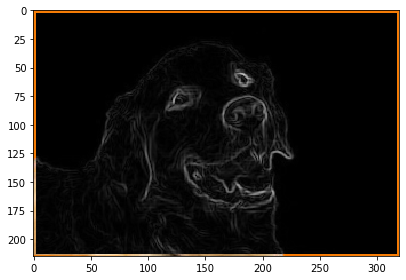

In [28]:
#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()
imshow(edges_img)

Save your image results.

In [ ]:
from skimage.io import imsave
imsave('edge_puppy.jpg', edges_img) 

### Activity 4

1. Append the set of cell images given in the directory 'test_images_day1' to a list, and display them using subplot from matplotlib. Extract the raw pixel feature vector for these images. 

The *os* and *os.path* modules include functions to interact with the file system. We will be using some of them below to retrieve the image files from 'test_images_day1' directory.

In [ ]:
from os import listdir
from os.path import isfile, join

mypath='comp-biology-2020/test_images_day1'

#listdir will retrieve the list of files and directories in the current directory, isfile will check whether the specified path is an existing regular file or not
#join will join the path components 'mypath' and 'f'.
files = [f for f in listdir(mypath) if isfile(join(mypath,f))]
images = np.empty(len(files), dtype=object)
for n in range(0, len(files)):
  #INSERT YOUR CODE HERE for reading each image and appending to the images list.

#INSERT YOUR CODE HERE to display images using subplot.

In [ ]:
#Extract the raw pixel feature vectors for the list of test images
#INSERT YOUR CODE HERE


### Activity 5 (Advanced)
Use the edge detection method we just discussed, and extract the features for the same set of images from Activity 4. Use the inbuilt method for Sobel filter in skimage, and then the detailed math method. 

Hint: Use the same list 'images' that you used in the previous activity, and first display the results with the horizontal Sobel filter applied using subplot (simply reuse your code from the previous activity), and then display the results with the vertical Sobel filter applied.



In [ ]:
#INSERT YOUR CODE HERE

### Activity 6 (Advanced)
Recall the explanation of Prewitt Filters, and Canny filters from the slides. Implement them using the inbuilt function in skimage, and we can discuss the results during the office hours. You can either use just the first image from test_images_day1, or all the images concatenated into a list (use 'images' from Activity 4)

Note: For each activity, save your image results using imsave, to display during the next session.

You can google the in-built function for Prewitt and Canny in skimage.filters

Feature extraction will not be used in the following days, this is just to give an introduction to image processing using basic Computer Vision techniques.

In [ ]:
#INSERT YOUR CODE HERE